In [93]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [94]:
df = pd.read_csv('AB_NYC_2019.csv')

In [95]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


<AxesSubplot:xlabel='price', ylabel='Count'>

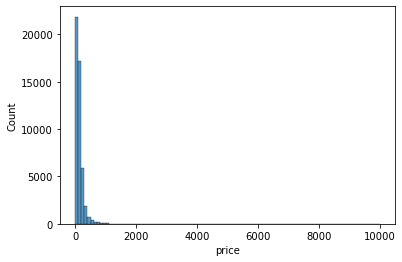

In [96]:
sns.histplot(df.price,bins = 100)

In [97]:
columns = ['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month',
          'calculated_host_listings_count','availability_365']

In [98]:
df_hw = df[columns]
df_hw.head(2)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355


In [99]:
df_hw.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [100]:
df_hw.minimum_nights.quantile(0.5)

3.0

In [101]:
df_hw.index

RangeIndex(start=0, stop=48895, step=1)

In [102]:
np.random.seed(42)

n = len(df)
# print ('length:%1f' % n)

n_train = int(n*0.6)
n_val = int(n*0.2)
n_test = int(n*0.2)

#putting the indices in an array
idx = np.arange(n)
# shuffling the indices
np.random.shuffle(idx)

# shuffling the dataframe
df_shuffled = df_hw.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

In [103]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']


## Question 3

In [105]:
def prepare (df,fill):
    df = df.fillna(fill)
    return df


In [106]:
## formalizing the equation
def train_linear_regression (X,y):
    #adding the bias or intercept
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [107]:
def rmse (y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [109]:
X_mean_train = prepare (df_train,df_train.reviews_per_month.mean())

w_0_mean, w_mean = train_linear_regression (X_mean_train,y_train)

In [110]:
print(w_0_mean)
print(w_mean)

-423.5393082023219
[ 1.31148321e+00 -5.06799071e+00 -4.87741552e-04 -6.63849280e-04
  5.34563274e-03  1.32706019e-03  6.38794182e-04]


In [111]:
X_mean_val = prepare (df_val, df_val.reviews_per_month.mean())

y_mean_pred_val = w_0_mean + X_mean_val.dot(w_mean)

In [113]:
rmse(y_val,y_mean_pred_val)

0.642753584752629

In [129]:
## filling blanks with zero

X_zero_train = prepare (df_train,0)

w_0_zero, w_zero = train_linear_regression (X_zero_train,y_train)


X_zero_val = prepare (df_val, 0)

y_zero_pred_val = w_0_zero + X_zero_val.dot(w_zero)

rmse(y_val,y_zero_pred_val)

0.6430337788467202

## Question 4

In [115]:
def train_linear_regression_reg (X,y, r=0.0):
    #adding the bias or intercept
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X)
    # creating a matrix with the regulization number on the diagnal
    reg = r * np.eye(XTX.shape[0])
    # adding that regulirization to the matrix
    XTX = XTX + reg
    
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [127]:
# seeing which r 

X_zero_train = prepare (df_train,0)
X_zero_val = prepare (df_val, 0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg (X_zero_train, y_train, r=r)
    y_zero_pred_val = w_0 + X_zero_val.dot(w)
    print('%10s %s' %(r,w_0), np.round(rmse(y_val, y_zero_pred_val),2))

         0 -419.91265866086724 0.64
     1e-06 -419.86271584310543 0.64
    0.0001 -414.9764926433289 0.64
     0.001 -375.27365274892543 0.64
      0.01 -191.7838405478213 0.66
       0.1 -32.562560550033176 0.68
         1 -3.499216833574792 0.68
         5 -0.7033623186161135 0.68
        10 -0.35127676047352 0.68


## Question 5

In [172]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_list = []

for seed in seeds:
    n = len(df)
    n_train = int(n*0.6)
    n_val = int(n*0.2)
    n_test = int(n*0.2)
    idx = np.arange(n)
    
    np.random.seed(seed)    
    
    np.random.shuffle(idx)

    df_shuffled = df_hw.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()
    
#     y_train_orig = df_train.price.values
#     y_val_orig = df_val.price.values
#     y_test_orig = df_test.price.values

    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)
    
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_zero_train = prepare (df_train,0)
    
#     print(X_zero_train.isnull().sum())

    w_0_zero, w_zero = train_linear_regression (X_zero_train,y_train)
    
    X_zero_val = prepare (df_val, 0)

    y_zero_pred_val = w_0_zero + X_zero_val.dot(w_zero)

    rmse_val = np.round(rmse(y_val,y_zero_pred_val),2)
    
    rmse_list.append(rmse_val)
    
    print(seed,w_0_zero,rmse_val)

0 -427.62844627426284 0.65
1 -414.70554908342683 0.65
2 -423.2541336360157 0.65
3 -421.8933158945776 0.64
4 -422.06099098594575 0.64
5 -429.178752276979 0.63
6 -427.4918955557489 0.63
7 -428.1884699089791 0.65
8 -427.6929118381776 0.65
9 -426.9826895542177 0.64


In [174]:
np.round(np.std(rmse_list),3)

0.008

## Question 6

In [178]:
np.random.seed(9)

n = len(df)
# print ('length:%1f' % n)

n_train = int(n*0.6)
n_val = int(n*0.2)
n_test = int(n*0.2)

#putting the indices in an array
idx = np.arange(n)
# shuffling the indices
np.random.shuffle(idx)

# shuffling the dataframe
df_shuffled = df_hw.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

df_full_train = pd.concat([df_train,df_val])
y_full_train = np.concatenate ([y_train,y_val])

In [181]:
X_zero_train = prepare (df_full_train,0)

w_0_zero_train_val, w_zero_train_val = train_linear_regression_reg (X_zero_train,y_full_train,r= 0.001)


X_zero_test = prepare (df_test, 0)

y_zero_pred_test = w_0_zero_train_val + X_zero_test.dot(w_zero_train_val)

rmse_test = np.round(rmse(y_test,y_zero_pred_test),2)


print(w_0_zero_train_val,rmse_test)

-389.1162938295895 0.65
